In this assignment, we analyze log data to derive security insights using PySpark. We parse structured log files, perform cleaning, and conduct analysis for failed logins, status code distributions, and unusual patterns like high-frequency requests from IPs. The purpose is to demonstrate the use of big data tools for real-time security monitoring and insights.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, regexp_extract, count, desc

**Initialize Spark Session**: A Spark session is created to process the log data.

In [ ]:
# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Log Data Analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

**Load Log Data**: The log file is loaded from the specified path as a raw text file.

In [ ]:
log_file_path = "/content/large_sample_log.txt"

In [ ]:
# Define log pattern for extracting fields
log_pattern = r'(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)\s(\S+)\s*(\S*)" (\d{3}) (\d+|-)'

192.168.1.1 - - [10/Oct/2024:13:55:36 +0000] "GET /index.html HTTP/1.1" 200 512


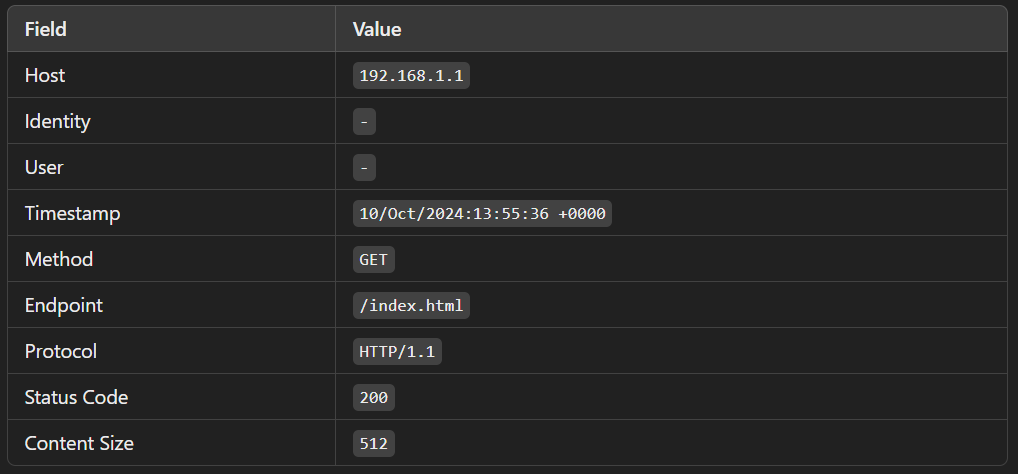

In [ ]:
# Step 3: Read the log data
raw_logs = spark.read.text(log_file_path)


**Parse Logs**: The logs are parsed using regular expressions to extract fields like IP address, timestamp, HTTP method, endpoint, status code, and content size.

In [ ]:
# Step 4: Parse the logs into structured data
logs_df = raw_logs.select(
    regexp_extract(col("value"), log_pattern, 1).alias("host"),
    regexp_extract(col("value"), log_pattern, 2).alias("identity"),
    regexp_extract(col("value"), log_pattern, 3).alias("user"),
    regexp_extract(col("value"), log_pattern, 4).alias("timestamp"),
    regexp_extract(col("value"), log_pattern, 5).alias("method"),
    regexp_extract(col("value"), log_pattern, 6).alias("endpoint"),
    regexp_extract(col("value"), log_pattern, 7).alias("protocol"),
    regexp_extract(col("value"), log_pattern, 8).alias("status"),
    regexp_extract(col("value"), log_pattern, 9).alias("content_size")
)

 **Data Cleaning**: Invalid or incomplete rows are filtered to ensure data quality.

In [ ]:
# Step 5: Data Cleaning
# Filter out incomplete or invalid rows
logs_df = logs_df.filter(col("host").isNotNull())

# Step 6: Security Analysis
# Example 1: Identify failed login attempts (status code 401)
failed_logins = logs_df.filter(col("status") == "401")

**Security Analysis**:
   - Failed Login Attempts: Identify and count failed logins (HTTP 401 status code).
   - Frequent Failed Login IPs: Detect IPs with the most failed logins.
   - Status Code Distribution: Analyze the distribution of HTTP status codes.
   - High-Frequency Requests: Identify IPs making more than 100 requests.


In [ ]:
# Count the number of failed attempts
failed_login_count = failed_logins.count()
print(f"Total Failed Login Attempts: {failed_login_count}")

# Example 2: Identify IPs with the most failed login attempts
top_failed_ips = failed_logins.groupBy("host").count().orderBy(desc("count"))
top_failed_ips.show(10, truncate=False)

# Example 3: Analyze the frequency of status codes
status_code_distribution = logs_df.groupBy("status").count().orderBy(desc("count"))
status_code_distribution.show()

# Example 4: Detect unusual patterns (e.g., high-frequency requests from a single IP)
high_frequency_ips = logs_df.groupBy("host").count().filter(col("count") > 100)
high_frequency_ips.show()

# Identify top endpoints accessed
top_endpoints = logs_df.groupBy("endpoint").count().orderBy(col("count").desc())
top_endpoints.show()

Total Failed Login Attempts: 5
+-----------+-----+
|host       |count|
+-----------+-----+
|192.168.1.2|1    |
|192.168.2.9|1    |
|192.168.1.6|1    |
|192.168.2.6|1    |
|192.168.2.2|1    |
+-----------+-----+

+------+-----+
|status|count|
+------+-----+
|   200|   10|
|   401|    5|
|   404|    3|
|   201|    1|
|   403|    1|
+------+-----+

+----+-----+
|host|count|
+----+-----+
+----+-----+

+---------------+-----+
|       endpoint|count|
+---------------+-----+
|         /login|    6|
|    /index.html|    4|
|    /about.html|    3|
|  /contact.html|    2|
|     /home.html|    1|
|/remove-account|    1|
|      /settings|    1|
|      /register|    1|
|/update-profile|    1|
+---------------+-----+



 **Save Results**: Save analysis results (e.g., failed logins) to a CSV file for reporting.

**Stop Spark Session**: Ends the Spark session to free resources.


In [ ]:
# Save the results of failed login analysis to a CSV file
output_path = "output/failed_logins"
failed_logins.write.csv(output_path, mode="overwrite", header=True)

# Stop Spark Session
spark.stop()

Analysis Results
Below are the insights derived from the analysis:
1. **Total Failed Login Attempts**: There were 5 failed login attempts in the dataset.
2. **Top IPs with Failed Logins**:
   - IP: 192.168.1.2, Count: 1
   - IP: 192.168.2.9, Count: 1
   - IP: 192.168.1.6, Count: 1
   - IP: 192.168.2.6, Count: 1
   - IP: 192.168.2.2, Count: 1
3. **Status Code Distribution**:
   - 200: 10 occurrences (successful requests).
   - 401: 5 occurrences (unauthorized requests).
   - 404: 3 occurrences (not found).
   - 201: 1 occurrence (created).
   - 403: 1 occurrence (forbidden).
4. **High-Frequency Requests**: No IPs made more than 100 requests in the dataset.
